In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.io
import matplotlib.pyplot as plt
import winsound

# Classe para armazenar o dataset

extende classe abstrada do pytorch com funções para iteração

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels = None):
        #'Initialization'
        self.labels = labels
        self.inputs = inputs

    def __len__(self):
        #'Denotes the total number of samples'
        return len(self.inputs)

    def __getitem__(self, index):
        # Load data and get label
        X = self.inputs[index]
        if self.labels is not None:
            y = self.labels[index]
        else:
            y = None
        return X, y

# Classe para o modelo da rede

In [3]:
class Net(nn.Module):
    def __init__(self,layers,lb, ub,net_f,  activation_func = torch.tanh, min_x = -1, max_x = 1, min_t = 0):
        # layers: lista com o numero de neuronios em cada camada
        # lb, ub: valores minimos e maximos das entradas (serve pra normalização dos dados)
        # l1, l2: coeficientes da equação de Burgers
        
        super(Net, self).__init__()
        
        self.layers = [] # Lista de camadas lineares (F.Linear)
        self.lb = torch.from_numpy(lb).float()
        self.ub = torch.from_numpy(ub).float()
        self.activation_func = activation_func
        self.MSE_u = nn.MSELoss()
        self.net_f = net_f
        
        self.min_x = min_x
        self.max_x = max_x
        self.min_t = min_t
        
        # Criação das camadas da rede
        for i in range(len(layers)-1):
            l = nn.Linear(layers[i], layers[i+1])
            torch.nn.init.xavier_normal_(l.weight) #inicialização dos pesos
            torch.nn.init.zeros_(l.bias)
            self.layers.append(l)
            
        self.linears = nn.ModuleList(self.layers) # instaciação das camadas da rede
  

    
    ## Função que percorre a rede
    def forward(self, x):
        # Normalização da entrada
        
        H = 2.0*(x - self.lb)/(self.ub - self.lb) - 1.0
        # Calculo da rede
        for l in (self.linears[:-1]):
            H = self.activation_func(l(H))
        H = self.linears[-1](H)
        return H
    
    def MSE_u(self, output, target, mascara):
        return torch.sum(torch.pow(output[mascara] - target[mascara],2))/torch.sum(mascara*1)
    
    #def MSE_u(self, output, target):
    #    return torch.pow(output - target,2).mean()
    
    def MSE_f(self, f, ):
        return (torch.pow(f,2)).mean()
    
    
    def net_u(self, x, t):
        u = self(torch.cat((x,t),1))
        return u

        
    def train_LBFGS(self, dataset, lr = 1, nIter = 1):
        optimizer = optim.LBFGS(self.parameters(),  lr=lr, max_iter=50000, max_eval=50000,\
                                tolerance_change=1e-09, history_size = 50, line_search_fn = None)
        self.it = 0
        
        for it in range(nIter):
            running_loss = 0.0
            for i, data in enumerate(dataset, 0):

                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                inputs.requires_grad_(True)
                x = inputs[:,0:1].float()
                t = inputs[:,1:2].float()
                labels = labels.float()
                with torch.no_grad():
                    c1 = x == self.min_x
                    c2 = x == self.max_x
                    c3 = t == self.min_t
                    m = (c1 | c2 | c3)
                    mascara = 1 * m
                    torch.cat(tensors, dim=0, *, out=None) → Tensor
                    
                # forward + backward + optimize

                def closure():
                    self.it += 1
                    optimizer.zero_grad()
                    outputs,f = self.net_f(self, x,t)
                    mse_f = self.MSE_f(f)
                    #o = outputs[m].unsqueeze(1)
                    #u_0 = labels[m.flatten()].unsqueeze(1)
                    mse_u = self.MSE_u(outputs,labels, m)
                    #mse_u = nn.MSELoss()(o,u_0)
                    loss = mse_f + mse_u
                    if self.it % 50 == 0:
                        print('[%5i] loss = %.3e,\t MSE_f = %.3e,\t MSE_u = %.3e' % (self.it, loss, mse_f, mse_u))
                    loss.backward()
                    return loss
                loss = optimizer.step(closure)
                print('it: %i >>> loss = %.3f' % (self.it, loss))
                
    def printLay(self):
        for i, l in enumerate(self.linears):
            print(l)


# Utils

In [4]:
def printResult(rede, dados, u_exato):
    with torch.no_grad():
        teste = torch.t(torch.tensor([dados[:,0].T,dados[:,1].T])).float()
        f_geral, axs1 = plt.subplots(1,2)
        rede2 = rede.forward(teste)
        
        vmin = min(u_exato)
        vmax = max(u_exato)

        pos0 = axs1[0].scatter(dados[:,1],dados[:,0],c=rede2.flatten(), vmin = vmin, vmax = vmax)
        pos1 = axs1[1].scatter(dados[:,1],dados[:,0],c=u_exato.flatten(), vmin = vmin, vmax = vmax)

        #axs1.plot(X_train[:,1], X_train[:,0],'rx')
        f_geral.colorbar(pos0, ax=axs1[0])
        f_geral.colorbar(pos1, ax=axs1[1])
        axs1[0].set_xlabel('t')
        axs1[0].set_ylabel('x')
        axs1[0].set_title('Predito')
        
        axs1[1].set_xlabel('t')
        axs1[1].set_ylabel('x')
        axs1[1].set_title('Exato')
        
        #f_geral.set_figheight(10)
        f_geral.set_figwidth(15)

In [5]:
def printTempos(rede, x, tempos, func = None):
    n = len(tempos);
    f_geral, axs = plt.subplots(1,n)
    f_geral.set_figwidth(7*n)
    
    with torch.no_grad():
        for i, t in enumerate(tempos, 0):
            X, T = np.meshgrid(x,t)

            grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
            inputs = torch.tensor(grid).float()
            val = rede(inputs)
            axs[i].plot(inputs[:,0],val, 'b', label = 'aprox rede')
            if (func != None):
                axs[i].plot(x,func(x,t), 'k--', label = 'val exato')
            
            axs[i].set_xlabel('x')
            axs[i].set_ylabel('u(x,t)')
            axs[i].set_title('t = %f' % t)
            axs[i].legend()

# Exemplos

In [ ]:
# Artigo 1
## f = u_t + l1 * uu_x + l2 * u_xx
def net_f(self, x, t):
    u = self(torch.cat((x,t),1))
    v = torch.ones(x.size())
    u_t = torch.autograd.grad(u,t,v, create_graph = True)[0]
    u_x = torch.autograd.grad(u,x,v, create_graph = True)[0]
    u_xx = torch.autograd.grad(u_x,x,v, create_graph = True)[0]
    
    #f = u_t + self.l1 * u * u_x - self.l2 * u_xx
    f = (u_t + 1.0 * u * u_x - (0.01/np.pi) * u_xx)
    return u,f

In [ ]:
# u = 1, F = 2cos(x + t)
def ex1_const(self, x, t):
    u = self(torch.cat((x,t),1))
    w = torch.ones(x.size())
    v = torch.ones(x.size())
    u_t = torch.autograd.grad(u,t,w, create_graph = True)[0]
    u_x = torch.autograd.grad(u,x,w, create_graph = True)[0]
    
    f = (u_t + v  * u_x) - (2.0 * torch.cos(x + t))
    return u,f

In [ ]:
# u = x, F = (1 + x)cos(x+t) - 4 - 2sin(x + t)
def ex1_linear(self, x, t):
    u = self(torch.cat((x,t),1))
    w = torch.ones(x.size())
    u_t = torch.autograd.grad(u,t,w, create_graph = True)[0]
    u_x = torch.autograd.grad(u,x,w, create_graph = True)[0]
    cos = torch.cos(x + t)
    grad_u = 1.0
    #f = u_t + x u_x - 2 * u
    f = (u_t + x * u_x - 2.0 * u) - (cos + x * cos - (grad_u * (2.0 + torch.sin(x + t)) + (2.0 + torch.sin(x + t)) * grad_u))
    return u,f

In [ ]:
# u = sin(x), F = (1 + x)cos(x+t) - 4 - 2sin(x + t)
def ex1_sin(self, x, t):
    u = self(torch.cat((x,t),1))
    w = torch.ones(x.size())
    u_t = torch.autograd.grad(u,t,w, create_graph = True)[0]
    u_x = torch.autograd.grad(u,x,w, create_graph = True)[0]
    cos = torch.cos(x + t)
    grad_u = torch.cos(x)
    #f = u_t + x u_x - 2 * u
    f = (u_t + torch.sin(x) * u_x - 2.0 * u * torch.cos(x)) - (cos + torch.sin(x) * cos - (grad_u * (2.0 + torch.sin(x + t)) + (2.0 + torch.sin(x + t)) * grad_u))
    return u,f

# Preparação dos dados

### Dados do artigo 1

In [ ]:
## Leitura do Dataset
data = scipy.io.loadmat('burgers_shock.mat')
    
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
    
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]       

c1 = X_star[:,0] == -1
c2 = X_star[:,0] == 1
c3 = X_star[:,1] == 0

mascara = (c1 | c2 | c3)


borda = X_star[mascara]
u_borda = u_star[mascara]

colocation = X_star[~mascara]
u_colocation = u_star[~mascara]

N_u = 200
N_f = 10000
Sample_Size = N_u + N_f
# Escolhe os dados
idx_nu = np.random.choice(borda.shape[0], N_u, replace=False)
idx_nf = np.random.choice(colocation.shape[0], N_f, replace=False)

b = borda[idx_nu]
c = colocation[idx_nf]

u_b = u_borda[idx_nu]
u_c = u_colocation[idx_nf] 

X_train_1 = np.concatenate((c,b))
u_train_1 = np.concatenate((u_c,u_b))

print(u_star.shape)
# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)
nu = 0.01/np.pi

dataset_train = Dataset(X_train_1,u_train_1)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=Sample_Size,
                                          shuffle=False)

### Dados para u  = 2 + sin(t + x)

In [ ]:
def func_exata(x,t):
    return  2 + np.sin(x + t)

In [ ]:
x2 = np.linspace(0,1,256)
t2 = np.linspace(0,1,256)
X2, T2 = np.meshgrid(x2,t2)

X2_star = np.hstack((X2.flatten()[:,None], T2.flatten()[:,None]))
u2_star = func_exata(X2_star[:,0], X2_star[:,1])
u2_star = np.reshape(u2_star, (u2_star.shape[0],1))

In [ ]:
lb2 = X2_star.min(0)
ub2 = X2_star.max(0)

c1 = X2_star[:,0] == 0
c2 = X2_star[:,0] == 1
c3 = X2_star[:,1] == 0

mascara2 = (c1 | c2 | c3)

borda2 = X2_star[mascara2]
u_borda2 = u2_star[mascara2]

colocation2 = X2_star[~mascara2]
u_colocation2 = u2_star[~mascara2]

N_u2 = 200
N_f2 = 10000
Sample_Size2 = N_u2 + N_f2
# Escolhe os dados
idx_nu2 = np.random.choice(borda2.shape[0], N_u2, replace=False)
idx_nf2 = np.random.choice(colocation2.shape[0], N_f2, replace=False)

b2 = borda2[idx_nu2]
c2 = colocation2[idx_nf2]

u_b2 = u_borda2[idx_nu2]
u_c2 = u_colocation2[idx_nf2] 

X_train_2 = np.concatenate((c2,b2))
u_train_2 = np.concatenate((u_c2,u_b2))

print(u_train_2.shape)
dataset_train_2 = Dataset(X_train_2,u_train_2)
trainloader2 = torch.utils.data.DataLoader(dataset_train_2, batch_size=Sample_Size2,
                                           shuffle=False)

In [ ]:
plt.scatter(X2_star[:,1],X2_star[:,0],c=u2_star.flatten())

# Testes

In [6]:
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [ ]:
net = Net(layers,lb,ub,net_f)

In [ ]:
net.train_LBFGS(trainloader,lr = 1,nIter = 1)
printResult(net, X_star)
printTempos(net, x, [0.25, 0.5, 0.75], func = func_exata)

In [ ]:
net_const = Net(layers,lb2,ub2,ex1_const, min_x = 0)

In [ ]:
net_const.train_LBFGS(trainloader2,lr = 1,nIter = 1)
    printResult(net_const, X2_star)
printTempos(net_const, x2, [0.25, 0.5, 0.75], func = func_exata)

In [ ]:
net_linear = Net(layers,lb2,ub2,ex1_linear, min_x = 0)

In [ ]:
net_linear.train_LBFGS(trainloader2,lr = 1,nIter = 1)
printResult(net_linear, X2_star)
printTempos(net_linear, x2, [0.25, 0.5, 0.75], func = func_exata)

In [ ]:
net_sin = Net(layers,lb2,ub2,ex1_sin, min_x = 0)

In [ ]:
net_sin.train_LBFGS(trainloader2,lr = 1,nIter = 1)
printResult(net_sin, X2_star)
printTempos(net_sin, x2, [0.25, 0.5, 0.75], func = func_exata)

In [ ]:
duration = 430  # milliseconds
freq = 500  # Hz
for i in range(3):
    winsound.Beep(freq, duration)

# Exemplo 2

\begin{align}
&\phi(x,t) = tanh(10x + t) + e^{-xt}\\
&F(x,t) = sech^2(t + 10x) [1 + 10u] - e^{-xt} [x + ut] - 2 \nabla u [tanh(10x + t) + e^{-xt}]
\end{align}

In [55]:
def func_exata_2(x,t):
    return np.tanh(75*x *t) + np.exp(-x  * t)

In [56]:
def ex2_const(self, x, t):
    phi = self(torch.cat((x,t),1))
    w = torch.ones(x.size())
    v = torch.ones(x.size())
    phi_t = torch.autograd.grad(phi,t,w, create_graph = True)[0]
    phi_x = torch.autograd.grad(phi,x,w, create_graph = True)[0]
    
    mult = 75
    
    u = 1
    grad_u = 0
    
    sech = 1/torch.cosh(t * mult*x)
    exp = torch.exp(-x  * t)
    f = (phi_t + u * phi_x - 2.0 * grad_u * phi) - (torch.pow(sech, 2) * mult *(x + t*u) - exp * (x + u*t) \
                                                    - 2 * grad_u * (torch.tanh(mult*x* t) + exp))
    return phi,f

In [57]:
def ex2_sin(self, x, t):
    phi = self(torch.cat((x,t),1))
    w = torch.ones(x.size())
    v = torch.ones(x.size())
    phi_t = torch.autograd.grad(phi,t,w, create_graph = True)[0]
    phi_x = torch.autograd.grad(phi,x,w, create_graph = True)[0]
    
    mult = 75
    
    u = torch.sin(x)
    grad_u = torch.cos(x)
    
    sech = 1/torch.cosh(t * 50*x)
    exp = torch.exp(-x  * t)
    f = (phi_t + u * phi_x - 2.0 * grad_u * phi) - (torch.pow(sech, 2) * mult *(x + t*u) - exp * (x + u*t) \
                                                    - 2 * grad_u * (torch.tanh(mult*x* t) + exp))
    return phi,f

In [58]:
x3 = np.linspace(-1,1,256)
t3 = np.linspace(0,1,256)
X3, T3 = np.meshgrid(x3,t3)

X3_star = np.hstack((X3.flatten()[:,None], T3.flatten()[:,None]))
u3_star = func_exata_2(X3_star[:,0], X3_star[:,1])
u3_star = np.reshape(u3_star, (u3_star.shape[0],1))

c1 = X3_star[:,0] == -1
c2 = X3_star[:,0] == 1
c3 = X3_star[:,1] == 0

mascara = (c1 | c2 | c3)


borda3 = X3_star[mascara]
u3_borda = u3_star[mascara]

colocation3 = X3_star[~mascara]
u3_colocation = u3_star[~mascara]

N_u = 200
N_f = 10000
Sample_Size = N_u + N_f
# Escolhe os dados
idx_nu = np.random.choice(borda3.shape[0], N_u, replace=False)
idx_nf = np.random.choice(colocation3.shape[0], N_f, replace=False)

b3 = borda3[idx_nu]
c3 = colocation3[idx_nf]

u3_b = u3_borda[idx_nu]
u3_c = u3_colocation[idx_nf] 

X_train_3 = np.concatenate((c3,b3))
u_train_3 = np.concatenate((u3_c,u3_b))


# Domain bounds
lb3 = X3_star.min(0)
ub3 = X3_star.max(0)

dataset3_train = Dataset(X_train_3,u_train_3)
trainloader3 = torch.utils.data.DataLoader(dataset3_train, batch_size=Sample_Size,
                                          shuffle=True)

tensor(200) torch.Size([10200, 1])
[   50] loss = 3.867e+01,	 MSE_f = 3.702e+01,	 MSE_u = 1.642e+00
[  100] loss = 2.645e+01,	 MSE_f = 2.630e+01,	 MSE_u = 1.580e-01
[  150] loss = 1.777e+01,	 MSE_f = 1.761e+01,	 MSE_u = 1.635e-01
[  200] loss = 1.614e+01,	 MSE_f = 1.593e+01,	 MSE_u = 2.055e-01
[  250] loss = 5.960e+00,	 MSE_f = 5.606e+00,	 MSE_u = 3.539e-01
[  300] loss = 1.129e+00,	 MSE_f = 1.026e+00,	 MSE_u = 1.031e-01
[  350] loss = 5.691e-01,	 MSE_f = 5.102e-01,	 MSE_u = 5.881e-02
[  400] loss = 3.970e-01,	 MSE_f = 3.413e-01,	 MSE_u = 5.563e-02
[  450] loss = 2.533e-01,	 MSE_f = 2.025e-01,	 MSE_u = 5.078e-02
[  500] loss = 2.012e-01,	 MSE_f = 1.510e-01,	 MSE_u = 5.023e-02
[  550] loss = 1.661e-01,	 MSE_f = 1.263e-01,	 MSE_u = 3.983e-02
[  600] loss = 1.367e-01,	 MSE_f = 1.042e-01,	 MSE_u = 3.251e-02
[  650] loss = 1.062e-01,	 MSE_f = 8.494e-02,	 MSE_u = 2.130e-02
[  700] loss = 7.826e-02,	 MSE_f = 5.859e-02,	 MSE_u = 1.967e-02
[  750] loss = 6.540e-02,	 MSE_f = 4.759e-02,	 MSE_u = 

[16800] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[16850] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[16900] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[16950] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17000] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17050] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17100] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17150] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17200] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17250] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17300] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17350] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17400] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17450] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17500] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17550] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17600] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17650] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17700] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17750] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17800] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[17850] loss 

[34200] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34250] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34300] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34350] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34400] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34450] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34500] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34550] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34600] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34650] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34700] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34750] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34800] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34850] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34900] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[34950] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[35000] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[35050] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[35100] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[35150] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[35200] loss = nan,	 MSE_f = nan,	 MSE_u = nan
[35250] loss 

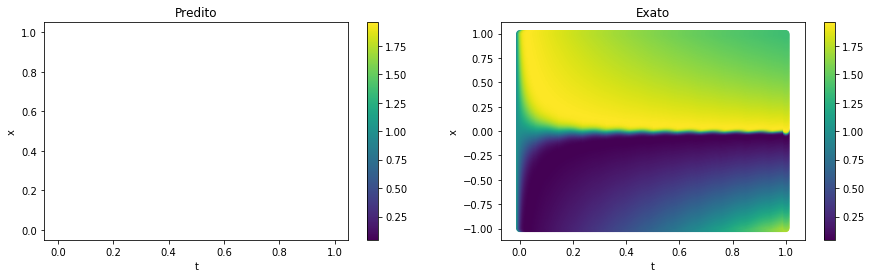

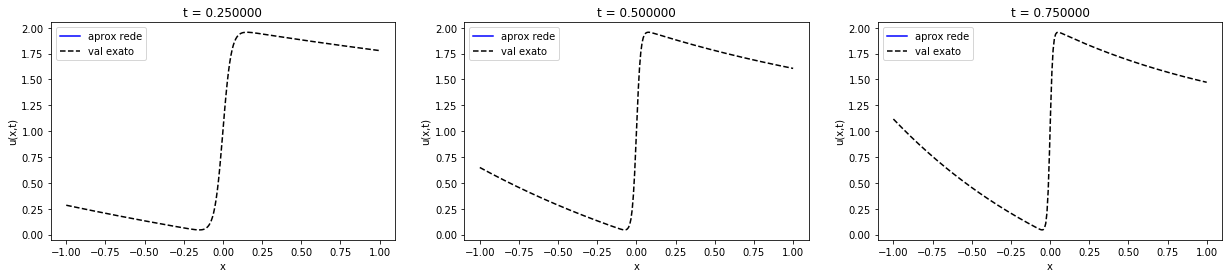

In [59]:
net_const2 = Net(layers,lb3,ub3,ex2_const)
net_const2.train_LBFGS(trainloader3,lr = 1,nIter = 1)
printResult(net_const2, X3_star, u3_star)
printTempos(net_const2, x3, [0.25, 0.5, 0.75], func = func_exata_2)

tensor(200) torch.Size([10200, 1])
it: 36 >>> loss = 53.095


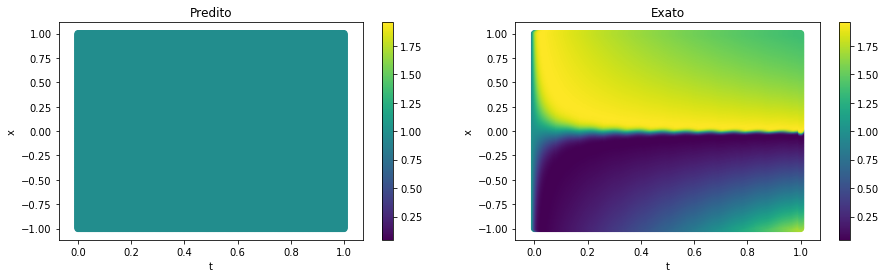

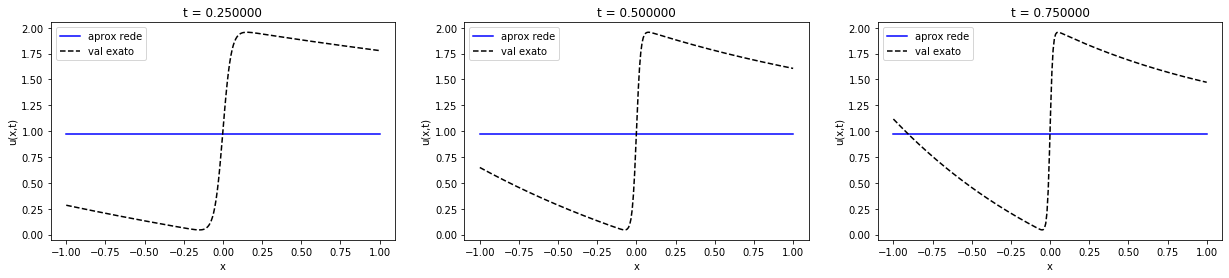

In [60]:
net_sin2 = Net(layers,lb3,ub3,ex2_sin)
net_sin2.train_LBFGS(trainloader3,lr = 1,nIter = 1)
printResult(net_sin2, X3_star, u3_star)
printTempos(net_sin2, x3, [0.25, 0.5, 0.75], func = func_exata_2)

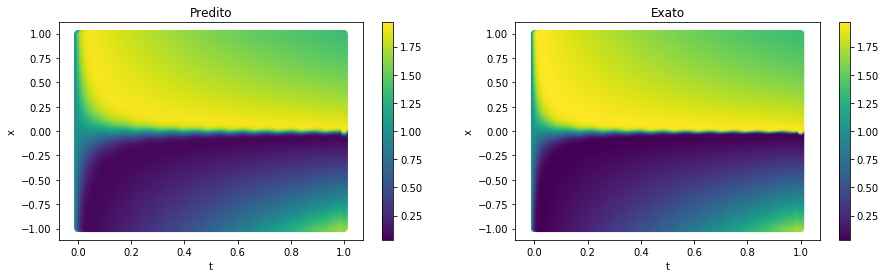

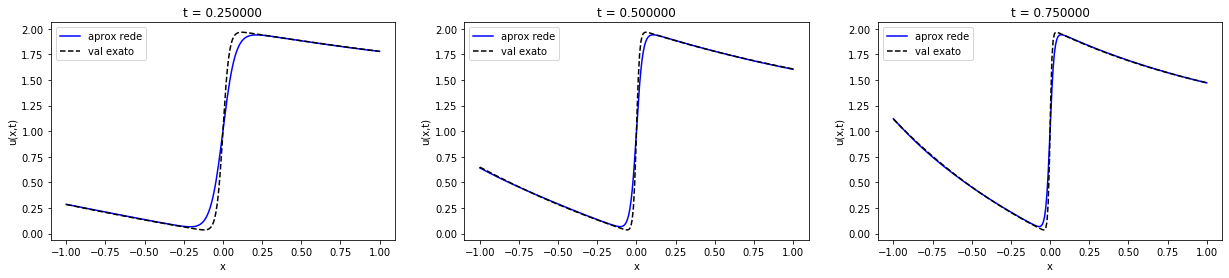

In [52]:
printResult(net_const2, X3_star, u3_star)
printTempos(net_const2, x3, [0.25, 0.5, 0.75], func = func_exata_2)

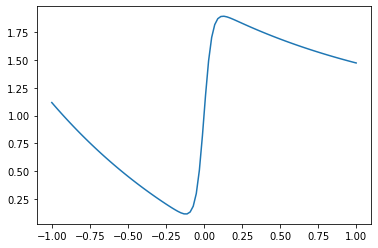

In [6]:
f  = lambda x,t: np.tanh(25*x *t) + np.exp(-x  * t)
x = np.linspace(-1,1,100)
t = .75
s = f(x,t)
plt.plot(x,s)